# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from utils.PytorchUtils import PytorchUtils
from utils.Visualisation import Visualisation

from dataset_creation.ImageCreation import ImageCreation

PyTorch version: 2.1.1+cu121


In [2]:
device = PytorchUtils.device_section()

In [3]:
WIDTH, HEIGHT = 128, 128
STROKE_SIZE = 3
IMAGE_FACTOR = 1.1
EPOCHS: int = 10
BATCH_SIZE: int = 16
MODEL = "conv-variational"

In [4]:
CONV_MODEL_DATA = "conv" in MODEL

In [5]:
resources_folder = 'resources/sketchrnn'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)
class_size = {}

data = []

for class_name in classes:
    data_class = np.load(os.path.join(resources_folder, 'sketchrnn_' + class_name + '.npz'), allow_pickle=True, encoding="latin1")

    class_size[class_name] = len(data_class)
    data.append(data_class)

print(f'loaded numpy bitmaps, {nb_classes} classes')
print(len(data))
print(data[0].keys())
print(len(data[0]['train']))
print(len(data[0]['valid']))
print(len(data[0]['test']))

loaded numpy bitmaps, 8 classes
8
KeysView(NpzFile 'resources/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid)
70000
2500
2500


## Dataset creation

In [6]:
from dataset_creation.DataManagerNpz import DataManagerNpz

data_manager = DataManagerNpz()

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = data_manager.parse_data(data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')
print(f'test dataset size : {len(test_data)}') 

training dataset size : 560000
validation dataset size : 20000
test dataset size : 20000


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

shuffled_test_data, shuffled_test_labels = data_manager.shuffle_dataset(test_data, test_labels)

In [8]:
from dataset_creation.StrokeImageDataset import StrokeImageDataset

len_subset = 8000
valid_test_subset = 2000

training_set = StrokeImageDataset(
        data=shuffled_training_data[:len_subset], 
        labels=shuffled_training_labels[:len_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

validation_set = StrokeImageDataset(
        data=shuffled_validation_data[:valid_test_subset], 
        labels=shuffled_validation_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

test_set = StrokeImageDataset(
        data=shuffled_test_data[:valid_test_subset], 
        labels=shuffled_test_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)
test_loaded_set = DataLoader(test_set, batch_size=BATCH_SIZE , shuffle=True)

In [9]:
print(f'training set distribution :\n{Visualisation.dataset_distribution(classes, training_set)}')
print(f'validation set distribution :\n{Visualisation.dataset_distribution(classes, validation_set)}')
print(f'test set distribution :\n{Visualisation.dataset_distribution(classes, test_set)}')

training set distribution :
{0: 997, 1: 989, 2: 987, 3: 1017, 4: 1005, 5: 1012, 6: 975, 7: 1018}
validation set distribution :
{0: 269, 1: 240, 2: 229, 3: 254, 4: 273, 5: 280, 6: 224, 7: 231}
test set distribution :
{0: 268, 1: 259, 2: 232, 3: 250, 4: 237, 5: 242, 6: 257, 7: 255}


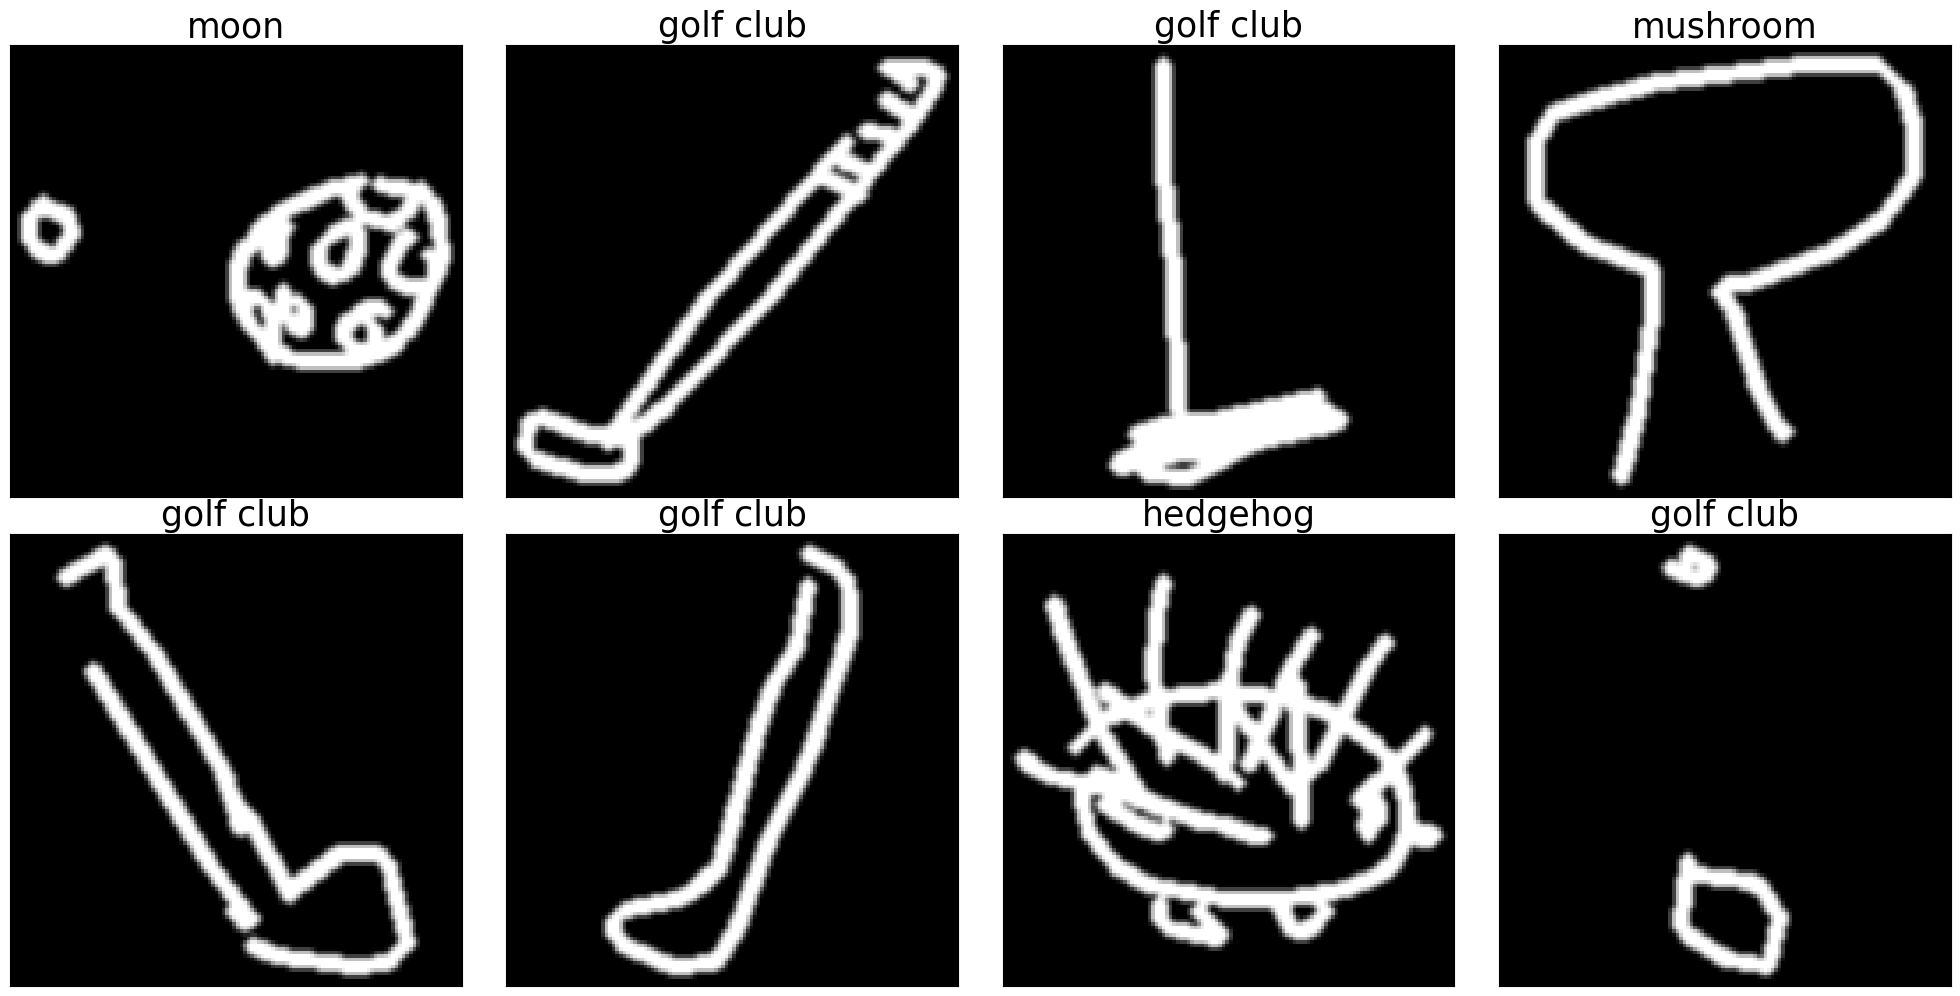

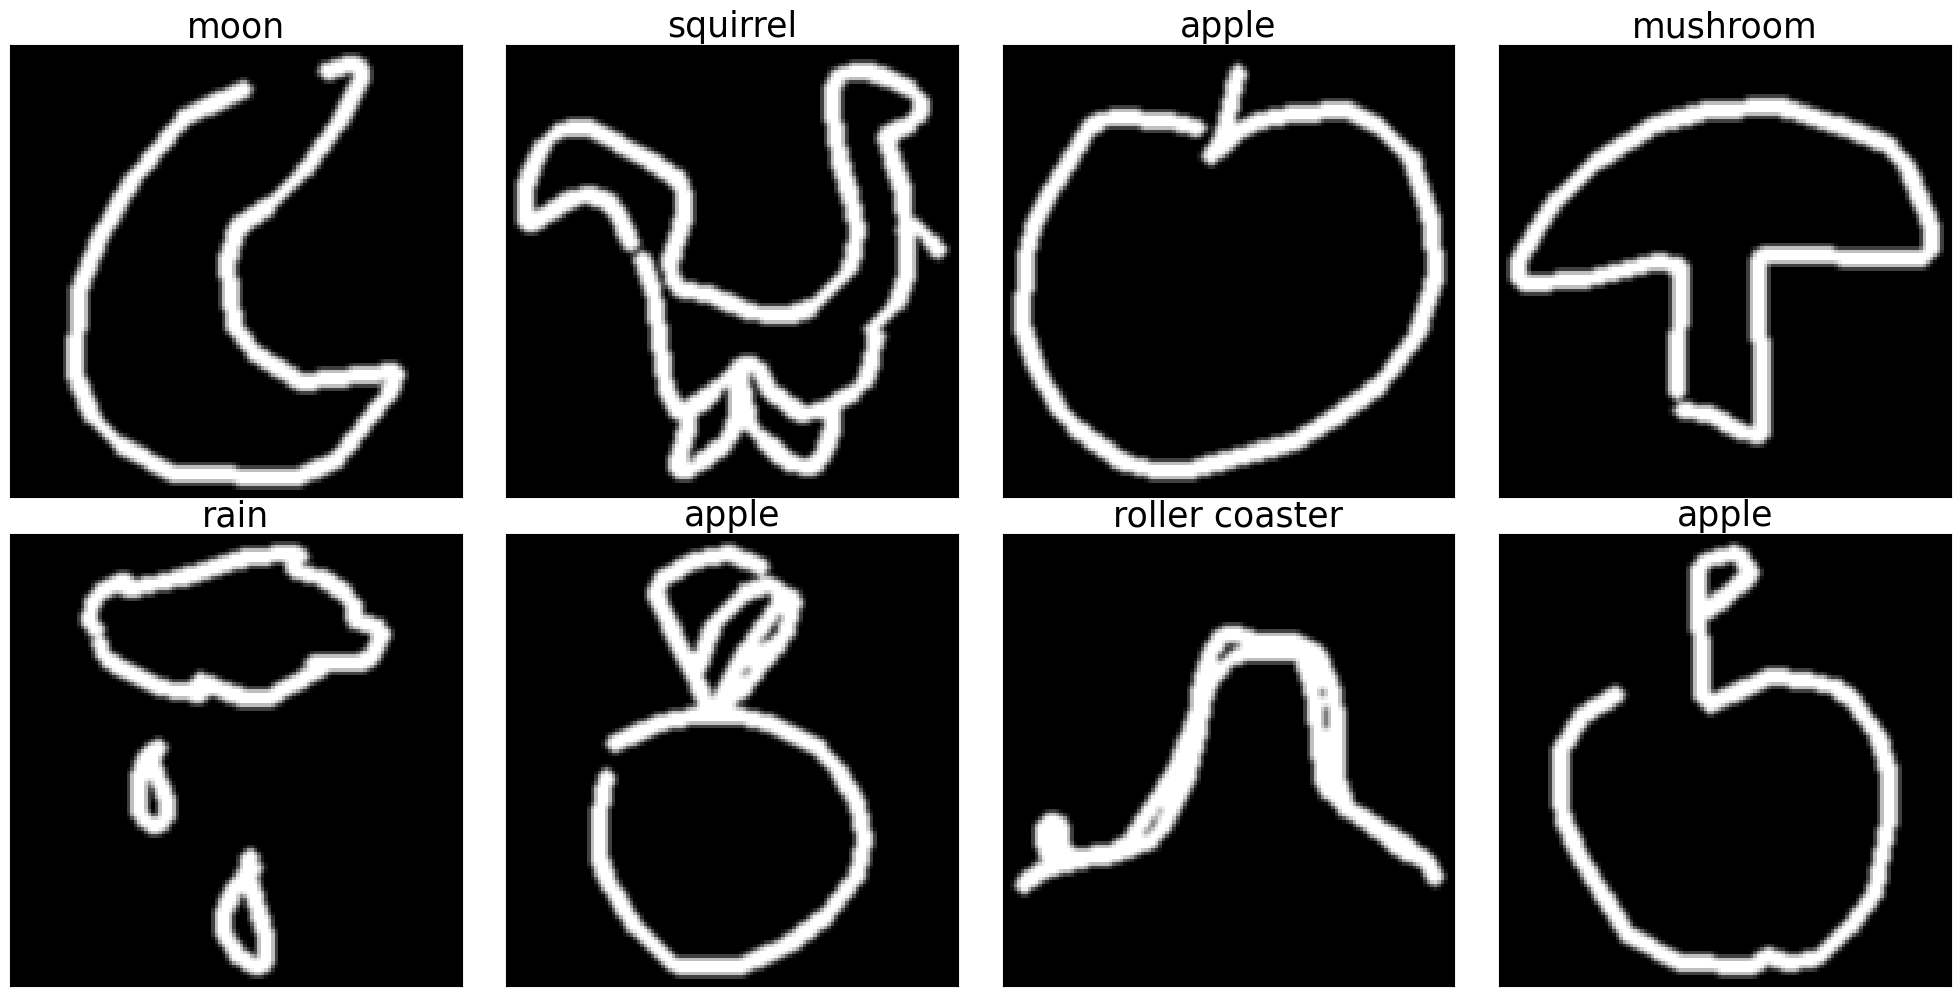

In [10]:
Visualisation.plot_random_images(training_set, classes)

Visualisation.plot_random_images(training_set, classes)

## Autoencoder class

In [11]:
from src.conv_autoencoder_embed import ConvAutoencoderEmbed
from src.conv_autoencoder import ConvAutoencoder
from src.conv_variational_autoencoder import ConvVariationalAutoencoder
from src.linear_autoencoder_embed import LinearAutoencoderEmbed
from src.linear_variational_autoencoder import LinearVariationalAutoencoder
from src.linear_autoencoder import LinearAutoencoder

## Try with simple model

In [12]:
conv_architecture = [1, 32, 16, 8]
linear_architecture = [WIDTH * HEIGHT, WIDTH * HEIGHT * 3 // 4]
rl=0.7
kl=0.3

MODEL_INIT = None
architecture = None
is_embed_model = False

if "conv" in MODEL or "convolutionnal" in MODEL:
    architecture = conv_architecture
    if "variational" in MODEL or "var" in MODEL:
        MODEL_INIT = ConvVariationalAutoencoder
        is_embed_model = False
    elif "embed" in MODEL or "embedded" in MODEL or "embedding" in MODEL:
        MODEL_INIT = ConvAutoencoderEmbed
        is_embed_model = True
    else:
        MODEL_INIT = ConvAutoencoder
elif "linear" in MODEL:
    architecture = linear_architecture
    if "variational" in MODEL or "var" in MODEL:
        MODEL_INIT = LinearVariationalAutoencoder
        is_embed_model = True
    elif "embed" in MODEL or "embedded" in MODEL or "embedding" in MODEL:
        MODEL_INIT = LinearAutoencoderEmbed
        is_embed_model = True
    else:
        MODEL_INIT = LinearAutoencoder

print("Chosen model : ", MODEL_INIT)

if "variational" in MODEL or "var" in MODEL:
    autoencoder_model = MODEL_INIT(architecture, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True, rl=rl, kl=kl)
else:
    autoencoder_model = MODEL_INIT(architecture, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True)
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = autoencoder_model.vae_loss if "variational" in MODEL else nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.0001)

Chosen model :  <class 'src.conv_variational_autoencoder.ConvVariationalAutoencoder'>


In [13]:
# Print architecture 
autoencoder_model.print_model()

nb_params = sum(p.numel() for p in autoencoder_model.parameters() if p.requires_grad)
print("Nb params", nb_params)

# Compression factor 
print(f'Compression factor: {(len(architecture)-2)*2}')

encoder :
Sequential(
  (encoder_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_relu_0): ELU(alpha=1.0)
  (encoder_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_dropout_0): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_relu_1): ELU(alpha=1.0)
  (encoder_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_dropout_1): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
latent space
Flatten(start_dim=1, end_dim=-1)
Linear(in_features=8192, out_features=16384, bias=True)
Linear(in_features=8192, out_features=8192, bias=

In [14]:
# Check if path exists for weight, else path not and will train

path = os.path.join(PytorchUtils.WEIGHTS_FOLDER, PytorchUtils.give_file_name(autoencoder_model, EPOCHS))

if not os.path.exists(path):
    path = None

autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, optimizer, criterion, EPOCHS, path=path)

loading weights from : weigths/ConvVariationalAutoencoder_128x128_10_epochs.pt
attempting to train 10 epochs but 10 epochs already done -> no training performed


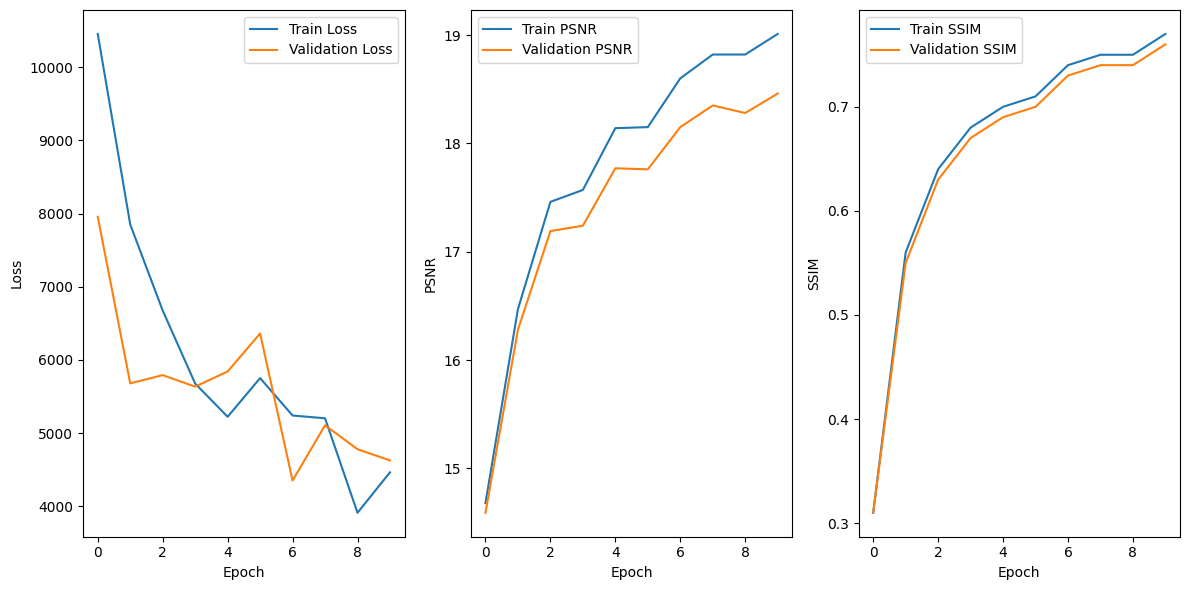

In [15]:
autoencoder_model.plot_psnr_ssim()

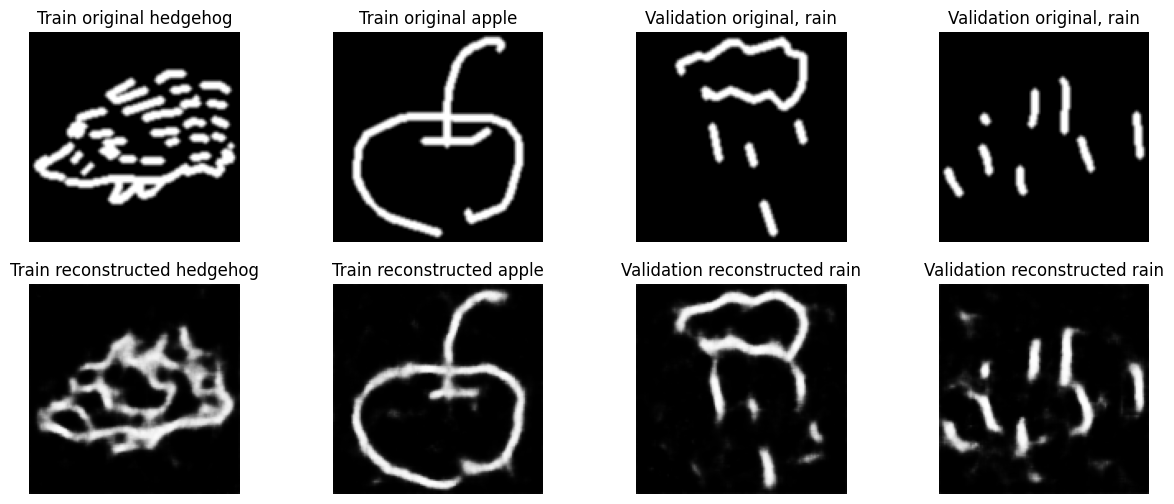

In [16]:
autoencoder_model.show_images(training_set, validation_set)

In [17]:
CHECK_BACTH_SIZE = 80

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [18]:
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

Lowest PSNR index: 2|12.234329117158483, Lowest SSIM index: 57|0.5168189301022738


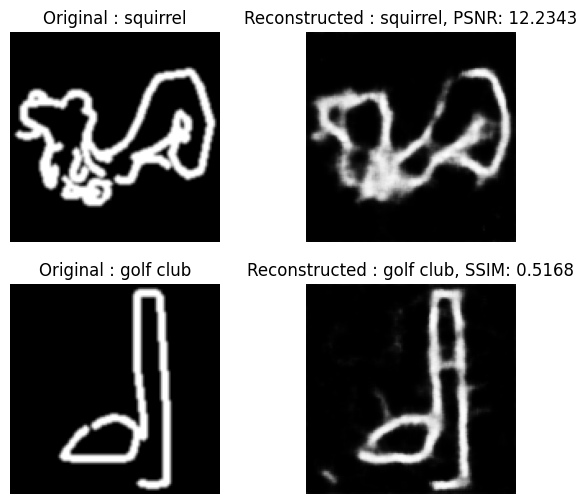

In [19]:
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

# Show latent space

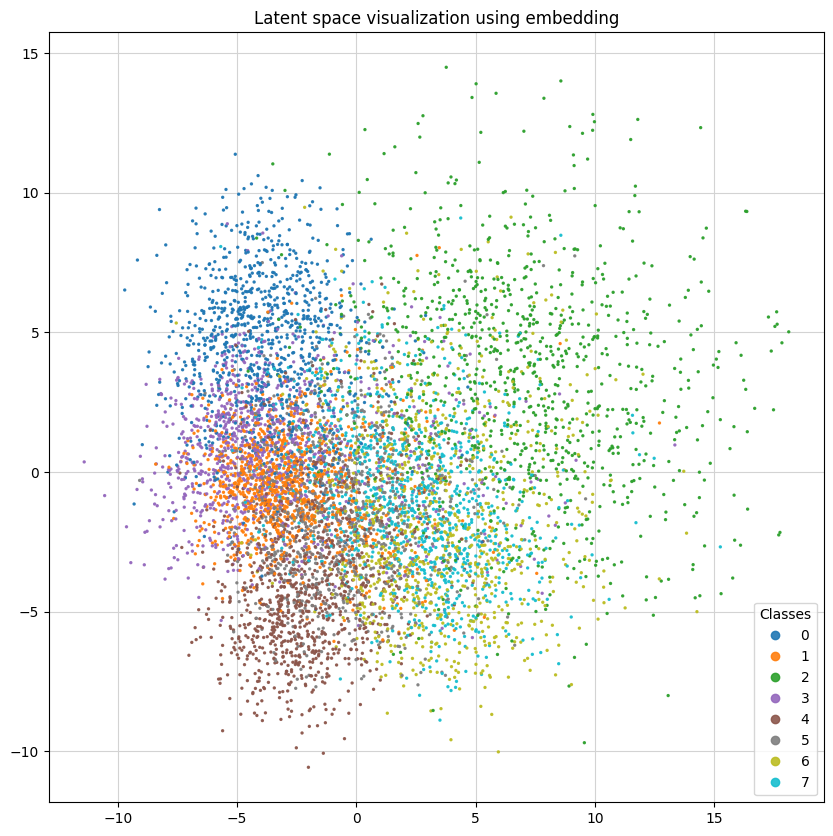

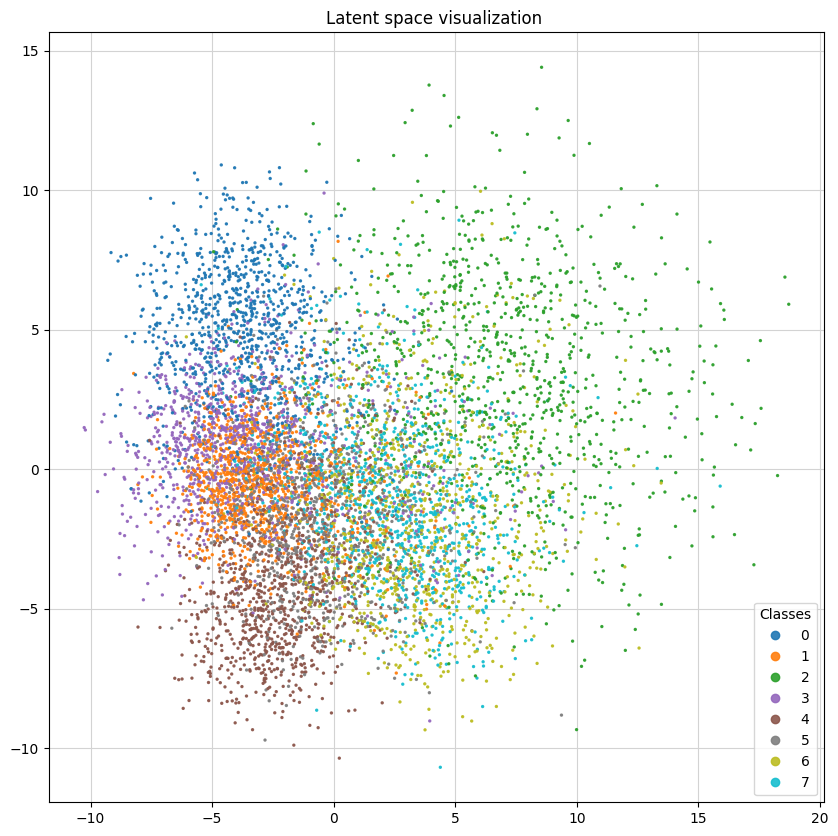

In [20]:
Visualisation.latent_space_visualization(autoencoder_model, training_loaded_set, use_embedding=True)
Visualisation.latent_space_visualization(autoencoder_model, training_loaded_set, use_embedding=False)

# Generating images

In [21]:
from src.generator import ImageGenerator

image_generator = ImageGenerator(classes, device, autoencoder_model)

Class apple range of mean encoded  vector: [-0.33501370767002536,0.31496093391161506]
Class golf club range of mean encoded  vector: [-0.26762527920478996,0.21878714670207733]
Class hedgehog range of mean encoded  vector: [-0.3904613325572379,0.4805429539593218]
Class moon range of mean encoded  vector: [-0.20993979427791334,0.2067071117914942]
Class mushroom range of mean encoded  vector: [-0.2899017418072147,0.2585296286446093]
Class rain range of mean encoded  vector: [-0.1836873768626808,0.16472676490422472]
Class roller coaster range of mean encoded  vector: [-0.28795621707844427,0.29336854702769183]
Class squirrel range of mean encoded  vector: [-0.2529656588793357,0.31094623881818506]
Class all range of mean encoded  vector: [-0.13375171278737252,0.14665862702252344]
has embedding: False


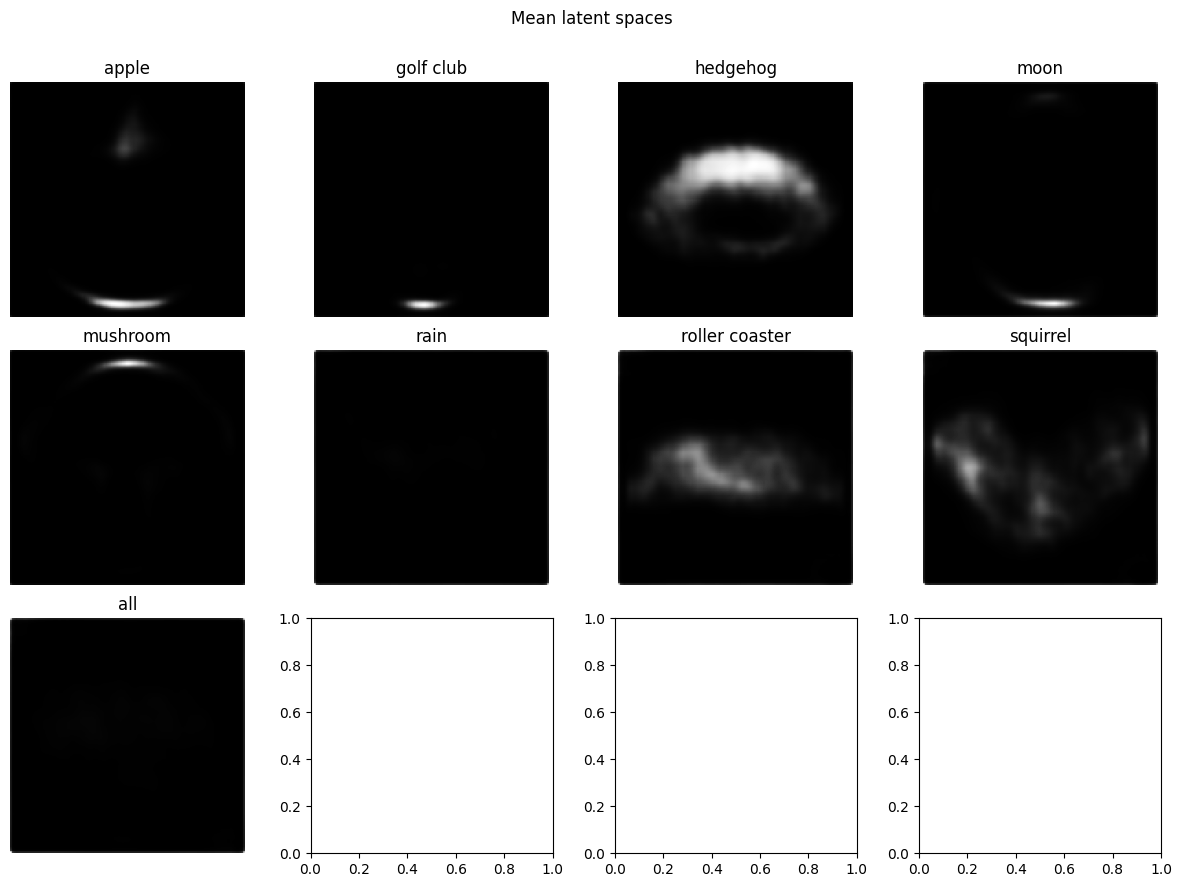

In [22]:
mean_encoded_information = image_generator.generate_mean_encoded_information(training_loaded_set)

has_embedding = "mean_before" in mean_encoded_information[0].keys()

print(f'has embedding: {has_embedding}')

mean_vectors1 = []
for i in range(len(mean_encoded_information)):
    mean_vectors1.append(mean_encoded_information[i]['mean'])

image_generator.show_generated_images_per_mean_vectors(
        mean_vectors1, 
        title=("Mean embedded latent spaces" if has_embedding else "Mean latent spaces"),
        image_size=(None if autoencoder_model.latent_type != "convolutional" else (WIDTH, HEIGHT)))

Class apple range of mean encoded  vector: [-0.3835805148893263,0.3460939165724137]
Class golf club range of mean encoded  vector: [-0.2560358377120809,0.2334269257215265]
Class hedgehog range of mean encoded  vector: [-0.425981792790217,0.5157323502147572]
Class moon range of mean encoded  vector: [-0.22904848519276788,0.19417917799303488]
Class mushroom range of mean encoded  vector: [-0.28542904242854655,0.2650386448208224]
Class rain range of mean encoded  vector: [-0.17190817154192994,0.17143118530217366]
Class roller coaster range of mean encoded  vector: [-0.33583123898658995,0.28291125564812086]
Class squirrel range of mean encoded  vector: [-0.2828909587261426,0.3036442799699513]
Class all range of mean encoded  vector: [-0.13858705387450754,0.15525019109825372]
has embedding: False


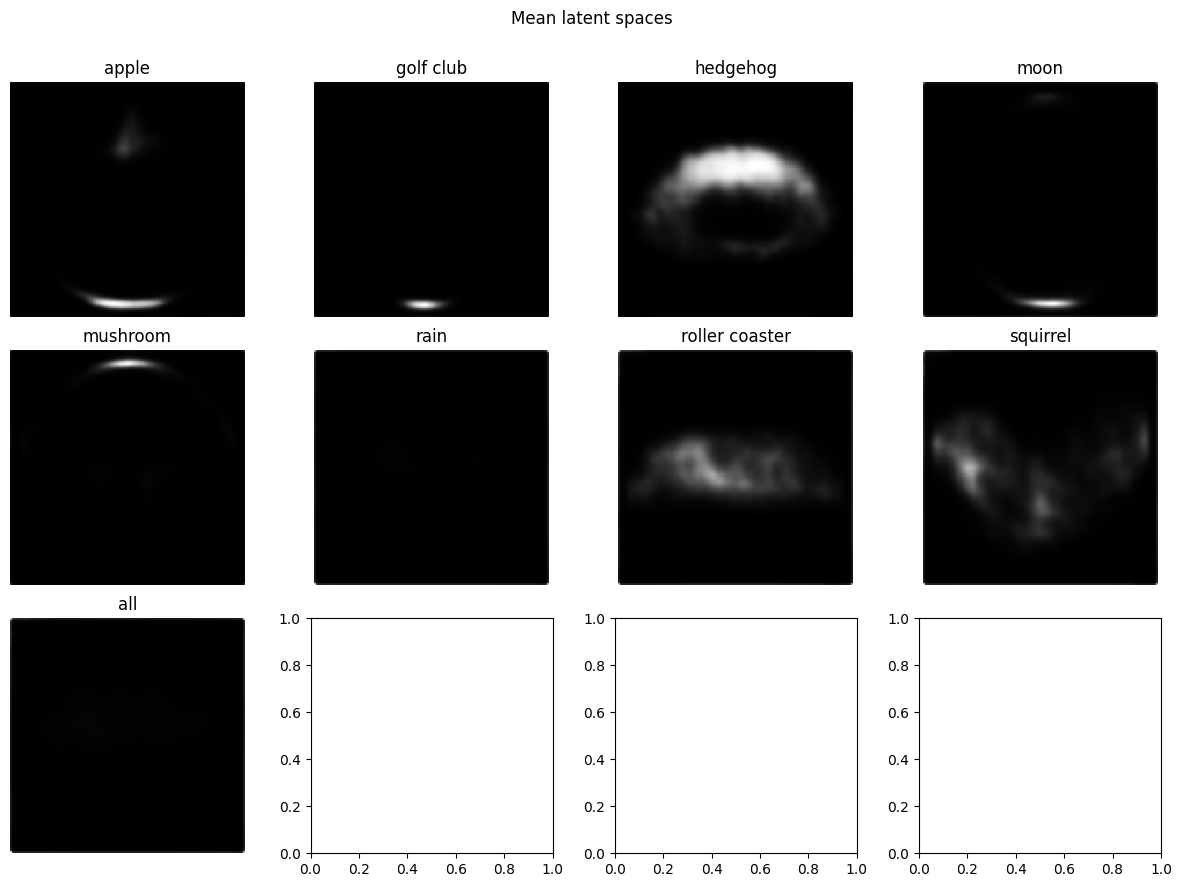

In [23]:
mean_encoded_information = image_generator.generate_mean_encoded_information(training_loaded_set)

has_embedding = "mean_before" in mean_encoded_information[0].keys()

print(f'has embedding: {has_embedding}')

mean_vectors1 = []
for i in range(len(mean_encoded_information)):
    mean_vectors1.append(mean_encoded_information[i]['mean'])

image_generator.show_generated_images_per_mean_vectors(
        mean_vectors1, 
        title=("Mean embedded latent spaces" if has_embedding else "Mean latent spaces"),
        image_size=(None if autoencoder_model.latent_type != "convolutional" else (WIDTH, HEIGHT)))

# Interpolation

### z_embed class (n) => z_embed' class (n)

In [24]:
def add(tuple, a, b, c):
    a += tuple[0]
    b += tuple[1]
    c += tuple[2]

from utils.DatasetUtils import DatasetUtils

n_images = 3
interpolation = 8

label_1 = 0
label_2 = 1
label_3 = 2

24
(128, 128)


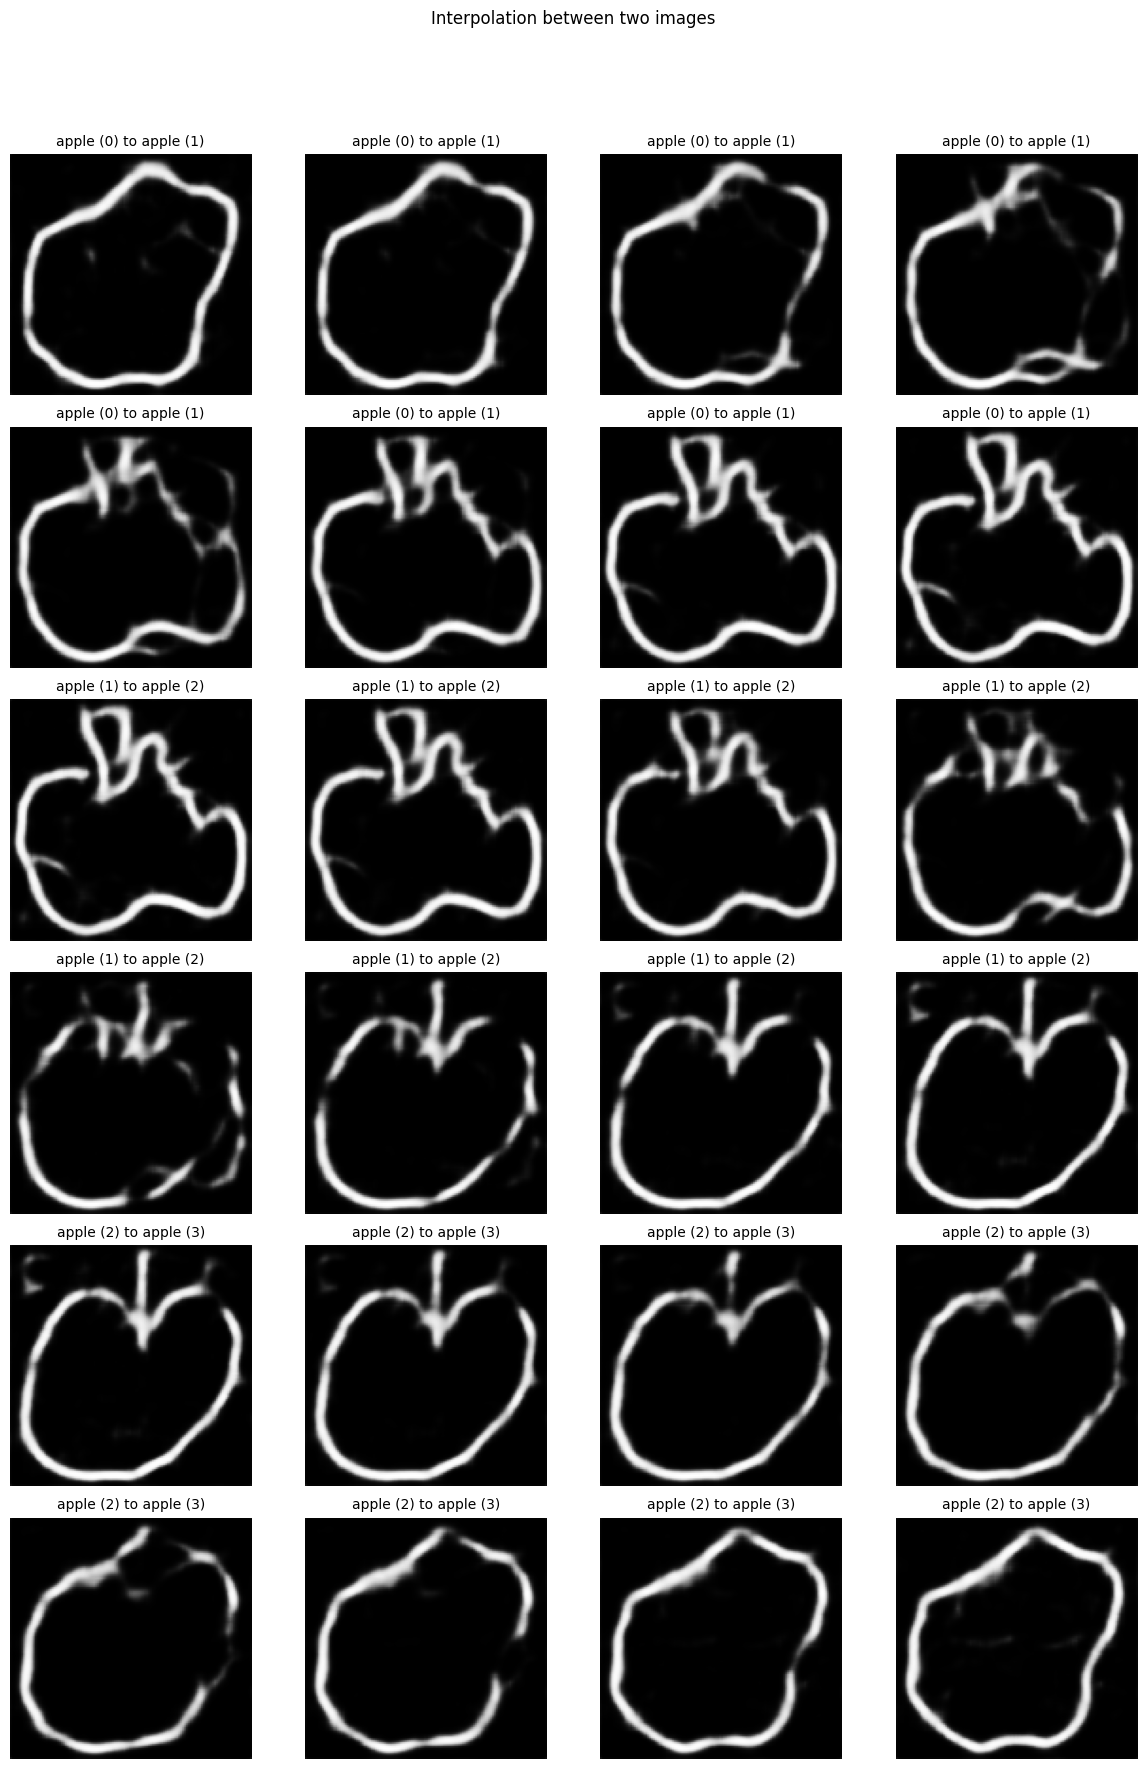

In [25]:
images, image_labels, image_indices = DatasetUtils.get_n_first_for_label(training_set, label_1, n_images)
images.append(images[0])
image_labels.append(image_labels[0])
image_indices.append(image_indices[0])

encoded = []
titles = []

with torch.no_grad():
    for i in range(len(images)):
        if i < len(images) - 1:
            for j in range(interpolation):
                titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")


        pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
        encoded.append(pack['encoded'])

    images = image_generator.interpolate_vectors(encoded, 
                                                interpolation_number=interpolation, 
                                                save_path="results/embed_n_to_n/", 
                                                image_size=(None if autoencoder_model.latent_type != "convolutional" else (WIDTH, HEIGHT)))

    image_generator.show_generated_images(images, 
                                        title="Interpolation between two images",
                                        titles=titles)

### z_embed class (n) => z_embed' class (m, n != m)

24
(128, 128)


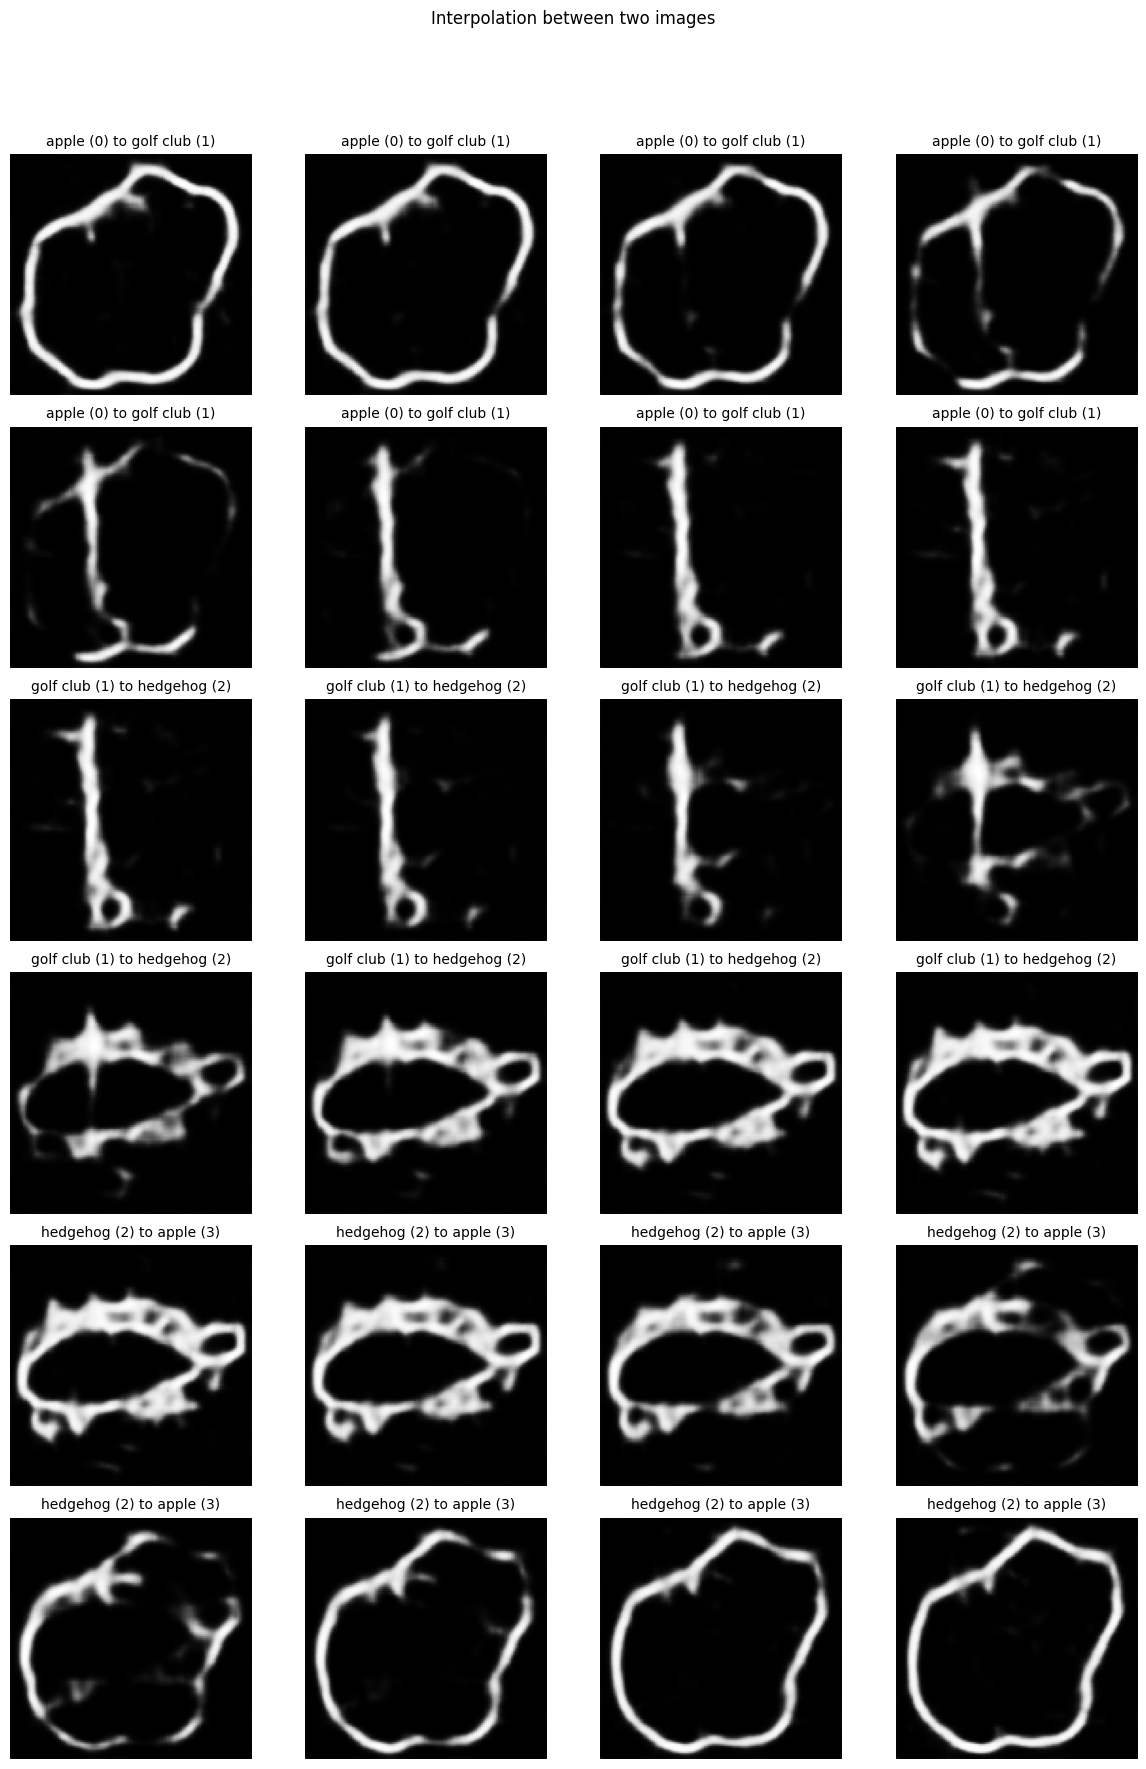

In [26]:
images, image_labels, image_indices = [], [], []

add(DatasetUtils.get_n_first_for_label(training_set, label_1, 1), images, image_labels, image_indices)
add(DatasetUtils.get_n_first_for_label(training_set, label_2, 1), images, image_labels, image_indices)
add(DatasetUtils.get_n_first_for_label(training_set, label_3, 1), images, image_labels, image_indices)

images.append(images[0])
image_labels.append(image_labels[0])
image_indices.append(image_indices[0])

encoded = []
titles = []

with torch.no_grad():
    for i in range(len(images)):
        if i < len(images) - 1:
            for j in range(interpolation):
                titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")


        pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
        encoded.append(pack['encoded'])

    images = image_generator.interpolate_vectors(encoded, 
                                                interpolation_number=interpolation, 
                                                save_path="results/embed_n_to_m/", 
                                                image_size=(None if autoencoder_model.latent_type != "convolutional" else (WIDTH, HEIGHT)))

    image_generator.show_generated_images(images, 
                                        title="Interpolation between two images",
                                        titles=titles)

### z (class n) + embed_class m => z' (class m, n != m) + embed_class n

In [27]:
if is_embed_model:
    images, image_labels, image_indices = [], [], []

    add(DatasetUtils.get_n_first_for_label(training_set, label_1, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_2, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_3, 1), images, image_labels, image_indices)

    images.append(images[0])
    image_labels.append(image_labels[0])
    image_indices.append(image_indices[0])

    encoded = []
    titles = []

    with torch.no_grad():
        for i in range(len(images)):
            if i < len(images) - 1:
                for j in range(interpolation):
                    titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")

            pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
            encoded.append(pack['encoded'])

        images = image_generator.interpolate_vectors(encoded, 
                                                    interpolation_number=interpolation, 
                                                    save_path="results/n_to_m_embed_before/", 
                                                    image_size=(None if autoencoder_model.latent_type != "convolutional" else (WIDTH, HEIGHT)),
                                                    labels=image_labels)

        image_generator.show_generated_images(images, 
                                            title="Interpolation between two images",
                                            titles=titles)

24


AttributeError: 'ConvVariationalAutoencoder' object has no attribute 'get_embed'

### z (class n) + embed_class m => z' (class m, n != m) + embed_class m

In [ ]:
if is_embed_model:

    images, image_labels, image_indices = [], [], []

    add(DatasetUtils.get_n_first_for_label(training_set, label_1, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_2, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_3, 1), images, image_labels, image_indices)

    images.append(images[0])
    image_labels.append(image_labels[0])
    image_indices.append(image_indices[0])

    encoded = []
    titles = []

    with torch.no_grad():
        for i in range(len(images)):
            if i < len(images) - 1:
                for j in range(interpolation):
                    titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")

            pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
            encoded.append(pack['encoded'])

        # move labels by one
        del image_labels[0]

        images = image_generator.interpolate_vectors(encoded, 
                                                    interpolation_number=interpolation, 
                                                    save_path="results/n_to_m_embed_after/", 
                                                    image_size=(None if autoencoder_model.latent_type != "convolutional" else (WIDTH, HEIGHT)),
                                                    labels=image_labels)

        image_generator.show_generated_images(images, 
                                            title="Interpolation between two images",
                                            titles=titles)

### z (class n) + embed_class m => z' (class m) + embed_class n, n !=m

In [ ]:
if is_embed_model:

    images, image_labels, image_indices = DatasetUtils.get_n_first_for_label(training_set, label_1, n_images)

    # take randomly another label without being the same as label_1
    other_label = random.randint(0, nb_classes - 1)
    other_labels = []

    images.append(images[0])
    image_labels.append(image_labels[0])
    image_indices.append(image_indices[0])

    encoded = []
    titles = []

    with torch.no_grad():
        for i in range(len(images)):
            if i < len(images) - 1:
                for j in range(interpolation):
                    titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")

            pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
            encoded.append(pack['encoded'])

            other_labels.append(other_label)


        images = image_generator.interpolate_vectors(encoded, 
                                                    interpolation_number=interpolation, 
                                                    save_path="results/n_to_m_embed_other/", 
                                                    image_size=(None if autoencoder_model.latent_type != "convolutional" else (WIDTH, HEIGHT)),
                                                    labels=other_labels)

        image_generator.show_generated_images(images, 
                                            title="Interpolation between two images + embedding " + str(classes[other_label]),
                                            titles=titles)